<a href="https://colab.research.google.com/github/matusoff/ML_models/blob/main/CNN_HotDog_vs_NOT_HotDog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow_datasets as tfds

In [ ]:
# TensorFlow has the food 101 dataset:
# https://www.tensorflow.org/datasets/catalog/food101

# Hot dog is label 55

In [6]:
ds, ds_info = tfds.load('food101', shuffle_files=True, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete8YINKR/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete8YINKR/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [7]:
#split our datasets into train and validation sets.
#This food dataset automatically comes with train and validation datasets
train_ds, valid_ds = ds["train"], ds["validation"]

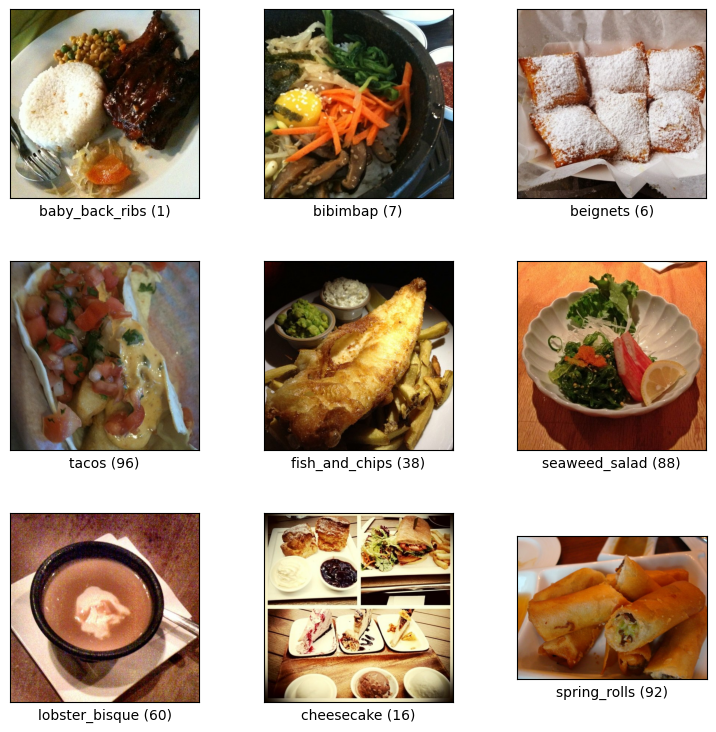

In [8]:
fig = tfds.show_examples(train_ds, ds_info)

In [8]:
'''
resize all pictures for the same size of square (128 x 128 pixels)
and cast the label equals to hotdog: 1 means a hotdog, 0 means not a hotdog
map() function: this function is doing that whatever function is in this map
will be applied to every single item in our dataset. and it will transform
the datset in that way
'''

MAX_SIDE_LEN = 128
HOT_DOG_CLASS = 55  # from the dataset
train_ds = train_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), tf.cast(label == HOT_DOG_CLASS, dtype=tf.int32)) # in the tuple we will have our new image and new label
)
valid_ds = valid_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), tf.cast(label == HOT_DOG_CLASS, dtype=tf.int32))
)

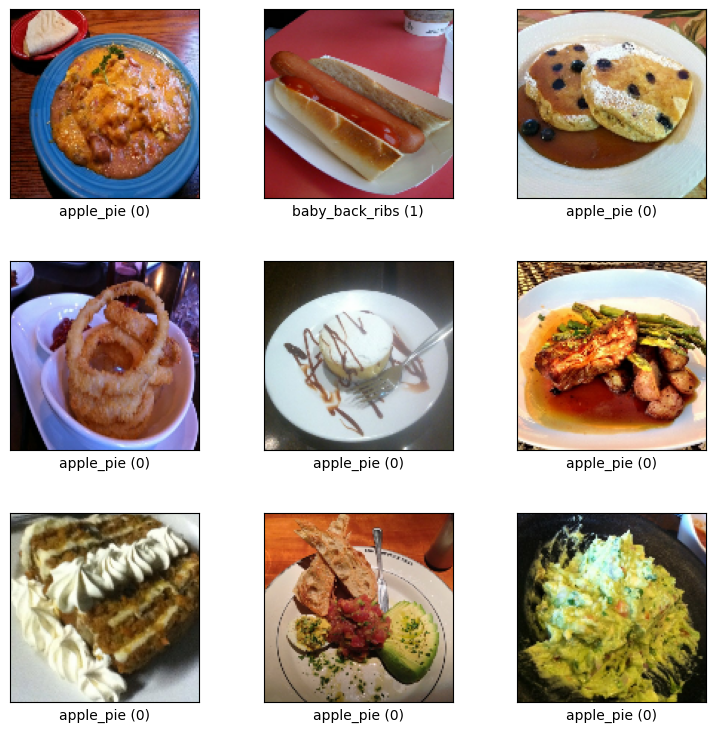

In [55]:
'''
verifying if this works
apple_pie label is a default label for zero in this dataset
and we see that hotdog image with label "baby_back_ribs" is equal to 1
'''
fig = tfds.show_examples(train_ds, ds_info)

In [9]:
# In this dataset, the images with hotdog are just a small fraction out of all images
# let's construct a new dataset by filtering labels that equal to 1

train_hd_size, valid_hd_size = 750, 250
train_hotdogs = train_ds.filter(lambda _, label: label == 1).repeat(3)
train_nothotdogs = train_ds.filter(lambda _, label: label == 0)

In [10]:
# Let's do the same for validation dataset

valid_hotdogs = valid_ds.filter(lambda _, label: label == 1).repeat(3)
valid_nothotdogs = valid_ds.filter(lambda _, label: label == 0)

In [11]:
valid_hotdogs

<_RepeatDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [12]:
# Sampling from each new datasets to get balanced dataset:
# 50% from train_hotdog and 50% from train_nothoddogs --> weights=[0.5, 0.5]

batch_size = 16
train_ds = tf.data.Dataset.sample_from_datasets([train_hotdogs, train_nothotdogs],
                                                weights=[0.5, 0.5],
                                                stop_on_empty_dataset=True)
'''
to get the training dataset into something that we can actually pass into our
neural net we're going to cache, batch and prefetch
cache - saving in the local storafe;
batch - we pass all batch of images to neural net
prefetch - to save time, while the model is training step N, the input pipeline
# is already reading the data for the next step
'''

train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.sample_from_datasets([valid_hotdogs, valid_nothotdogs],
                                                weights=[0.5, 0.5],
                                                stop_on_empty_dataset=True)
valid_ds = valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [13]:
# 16 vectors of the different labels in 0 (not hotdog) and 1 (hotdog)

for image, label in train_ds.take(3):
  print(image[0][0][0])
  print(label)

tf.Tensor([22 24 44], shape=(3,), dtype=int32)
tf.Tensor([0 1 0 0 1 0 1 0 0 1 1 1 1 1 1 1], shape=(16,), dtype=int32)
tf.Tensor([ 82 107 132], shape=(3,), dtype=int32)
tf.Tensor([0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 1], shape=(16,), dtype=int32)
tf.Tensor([44 35 30], shape=(3,), dtype=int32)
tf.Tensor([0 0 1 0 1 0 1 0 0 1 1 1 0 0 0 0], shape=(16,), dtype=int32)


Neural Net Implementation


In [14]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [15]:
random.seed(0)
model = models.Sequential()
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(MAX_SIDE_LEN, MAX_SIDE_LEN, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1))

In [16]:
lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs,
  verbose=1
)

Epoch 1/50
281/281 [==============================] - 1080s 4s/step - loss: 1.5281 - accuracy: 0.5189 - val_loss: 1.2069 - val_accuracy: 0.5206
Epoch 2/50
281/281 [==============================] - 499s 2s/step - loss: 1.0502 - accuracy: 0.5579 - val_loss: 0.9345 - val_accuracy: 0.5704
Epoch 3/50
281/281 [==============================] - 499s 2s/step - loss: 0.8729 - accuracy: 0.5915 - val_loss: 0.8273 - val_accuracy: 0.5637
Epoch 4/50
281/281 [==============================] - 510s 2s/step - loss: 0.7870 - accuracy: 0.6114 - val_loss: 0.7630 - val_accuracy: 0.6301
Epoch 5/50
281/281 [==============================] - 501s 2s/step - loss: 0.7278 - accuracy: 0.6325 - val_loss: 0.7279 - val_accuracy: 0.6580
Epoch 6/50
281/281 [==============================] - 540s 2s/step - loss: 0.6791 - accuracy: 0.6673 - val_loss: 0.7030 - val_accuracy: 0.6846
Epoch 7/50
281/281 [==============================] - 488s 2s/step - loss: 0.6322 - accuracy: 0.7009 - val_loss: 0.6857 - val_accuracy: 0.699

In [17]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in valid_ds.take(1):
  images = image_batch
  labels = label_batch

<Figure size 1000x1000 with 0 Axes>

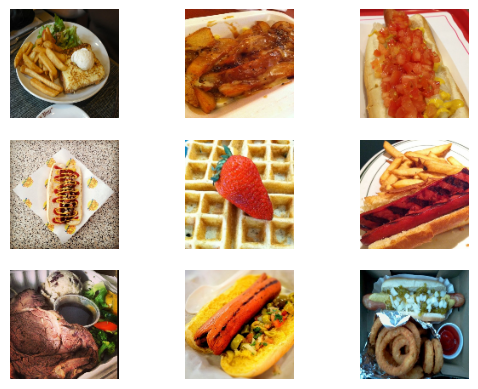

In [18]:
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(images[i])
  plt.axis("off")

In [19]:
labels[:9]

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([0, 0, 1, 1, 0, 1, 0, 1, 1], dtype=int32)>